In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [3]:
from google.colab import files
files.upload()

MessageError: ignored

In [0]:
!cp kaggle.json ~/.kaggle/

In [2]:
from getpass import getpass
import os

user = getpass('Github user')
password = getpass('Github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

#!git clone https://$GITHUB_AUTH@github.com/mett29/DL-Competition.git
#!git submodule update --init --recursive
!git clone https://$GITHUB_AUTH@github.com/DanieleParravicini/DL-CompetitionsDatasets
os.environ['GITHUB_AUTH'] = ''

Github user··········
Github password··········
Cloning into 'DL-CompetitionsDatasets'...
remote: Enumerating objects: 2079, done.
remote: Total 2079 (delta 0), reused 0 (delta 0), pack-reused 2079
Receiving objects: 100% (2079/2079), 90.16 MiB | 35.51 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [28]:
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [5]:
PATH = "DL-CompetitionsDatasets/Classification_Dataset"
!tree {PATH} -d

/bin/bash: tree: command not found


In [0]:
SEED = 1234
tf.random.set_seed(SEED) 

In [0]:
apply_data_augmentation = True

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(rotation_range=10,                   
                                        zoom_range=0.2,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        shear_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        fill_mode='nearest',
                                        cval=0,
                                        rescale=1./255,
                                        validation_split=0.2)
else:
    train_data_gen = ImageDataGenerator(rescale=1./255,
                                        fill_mode='reflect',
                                        cval=0,
                                        validation_split=0.2)

# Create test ImageDataGenerator objects
test_data_gen = ImageDataGenerator(rescale=1./255)

In [8]:
batch_size = 64
no_epochs = 30
no_classes = 20

IMG_HEIGHT = 200
IMG_WIDTH = 200

decide_class_indices = False
if decide_class_indices:
    classes = ['airplanes',           # 0
               'bear',                # 1
               'calculator',          # 2
               'computer-monitor',    # 3
               'fireworks',           # 4
               'galaxy',              # 5
               'grand-piano',         # 6
               'kangaroo',            # 7
               'laptop',              # 8
               'lightbulb',           # 9
               'lightning',           # 10
               'mountain-bike',       # 11
               'owl',                 # 12
               'school-bus',          # 13
               'sheet-music',         # 14
               'skyscraper',          # 15
               'sword',               # 16
               't-shirt',             # 17
               'waterfall',           # 18
               'wine-bottle']         # 19
else:
    classes=None

dataset_dir = os.path.join(PATH, 'training')

train_gen = train_data_gen.flow_from_directory(dataset_dir,
                                               batch_size=batch_size,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training',
                                               seed=SEED)

# Validation
valid_gen = train_data_gen.flow_from_directory(dataset_dir,
                                               batch_size=batch_size, 
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset='validation',
                                               seed=SEED)

Found 1247 images belonging to 20 classes.
Found 307 images belonging to 20 classes.


In [0]:
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, IMG_HEIGHT, IMG_WIDTH, 3], [None, no_classes]))

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, IMG_HEIGHT, IMG_WIDTH, 3], [None, no_classes]))

valid_dataset = valid_dataset.repeat()

In [10]:
train_gen.class_indices

{'airplanes': 0,
 'bear': 1,
 'calculator': 2,
 'computer-monitor': 3,
 'fireworks': 4,
 'galaxy': 5,
 'grand-piano': 6,
 'kangaroo': 7,
 'laptop': 8,
 'lightbulb': 9,
 'lightning': 10,
 'mountain-bike': 11,
 'owl': 12,
 'school-bus': 13,
 'sheet-music': 14,
 'skyscraper': 15,
 'sword': 16,
 't-shirt': 17,
 'waterfall': 18,
 'wine-bottle': 19}

In [0]:
# This function will plot images in the form of a grid with 1 row and 4 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 4, figsize=(15, 15))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

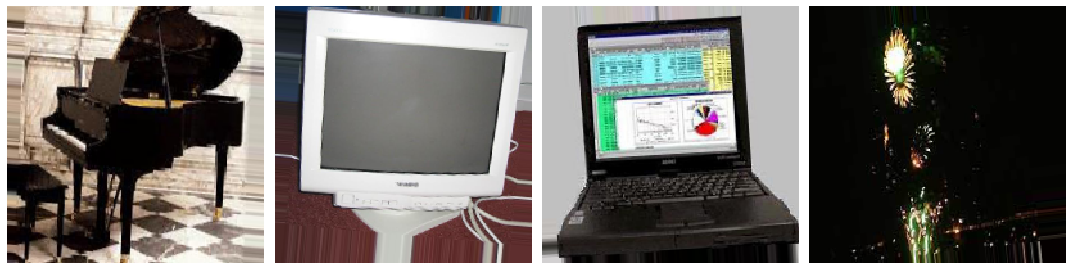

In [12]:
sample_training_images, _ = next(train_gen)
plotImages(sample_training_images[:4])

In [13]:
model = Sequential([
    Conv2D(32, 5, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, 5, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    Conv2D(128, 5, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    Conv2D(256, 5, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(20, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 128)       0

In [0]:
# Optimization parameters
loss = tf.keras.losses.CategoricalCrossentropy()
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = ['accuracy']

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [16]:
history = model.fit(x=train_dataset,
          epochs=no_epochs,
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen)
         )

# Save weights
model.save_weights('second_try.h5')

Train for 20 steps, validate for 5 steps
Epoch 1/30
20/20 [==============================] - 379s 19s/step - loss: 3.1054 - accuracy: 0.0545 - val_loss: 2.9926 - val_accuracy: 0.0651
Epoch 2/30
20/20 [==============================] - 374s 19s/step - loss: 2.9742 - accuracy: 0.0658 - val_loss: 2.9309 - val_accuracy: 0.0717
Epoch 3/30
20/20 [==============================] - 374s 19s/step - loss: 2.8980 - accuracy: 0.0930 - val_loss: 2.9369 - val_accuracy: 0.1270
Epoch 4/30
20/20 [==============================] - 374s 19s/step - loss: 2.8219 - accuracy: 0.1299 - val_loss: 2.6980 - val_accuracy: 0.1824
Epoch 5/30
20/20 [==============================] - 373s 19s/step - loss: 2.7688 - accuracy: 0.1636 - val_loss: 2.6879 - val_accuracy: 0.1889
Epoch 6/30
20/20 [==============================] - 375s 19s/step - loss: 2.6615 - accuracy: 0.1957 - val_loss: 2.6322 - val_accuracy: 0.1824
Epoch 7/30
20/20 [==============================] - 374s 19s/step - loss: 2.5295 - accuracy: 0.2077 - val_l

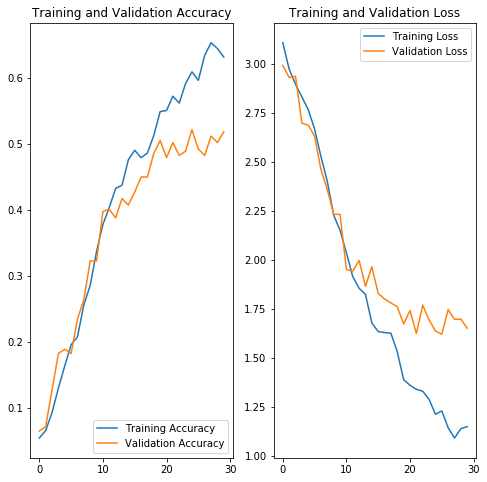

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(no_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()